<h1 style="color:red; text-align:center; text-decoration:underline;">Autoencodeurs Variationnels (Variational Autoencoders - VAE)</h1>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

# from tensorflow.python.framework.ops import disable_eager_execution

# disable_eager_execution()

In [2]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

# Data Preparation

For this implementation, we’ll be using the Fashion-MNIST dataset - a collection of grayscale images of clothing items, each of size 28x28 pixels. (show img from internet)

In [3]:

 (x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()


Ces images sont à l’origine en 28 × 28 en niveaux de gris avec des valeurs de pixels allant de 0 à 255.
Pour les rendre adaptées à notre réseau, nous allons les prétraiter en mettant à l’échelle les valeurs de pixels pour qu’elles soient comprises entre 0 et 1.
De plus, nous allons compléter les images pour qu’elles aient une taille de 32 × 32 afin de simplifier le traitement des données dans le réseau.

# Prétraitement des données

In [4]:
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [5]:
# display(x_train)

# Conception et construction de l’autoencodeur variationnel

Tout d’abord, nous devons créer une nouvelle couche d’échantillonnage pour prélever des échantillons à partir de la distribution définie par z_mean et z_log_var.

In [6]:
#Sampling Layer

class Sampling(layers.Layer):
    #We create a new layer by subclassing the keras base Layer
    def call(self, inputs):
        #
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
# Encoder

image_size = 32
embed_dim = 2
encoder_input = layers.Input(
    shape=(image_size, image_size, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)

#Instead of connecting the Flatten layer directly to the 2D latent space,
#we will connect it to layers z_mean and z_log_var.
z_mean = layers.Dense(embed_dim, name="z_mean")(x)
z_log_var = layers.Dense(embed_dim, name="z_log_var")(x)

#The Sampling layer samples a point z in the latent space from the
#normal distribution defined by the parameters z_mean and z_log_var.
z = Sampling()([z_mean, z_log_var])

#The Keras Model that defines the encoder—a model that takes an input
#image and outputs z_mean, z_log_var and a sampled point z from the
#normal distribution defined by these parameters.
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)    │ (None, 32, 32, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 16, 16, 32)        │             320 │ encoder_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 8, 8, 64)          │          18,496 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 4, 4, 128)         │          73,856 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 2048)              │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_mean (Dense)                │ (None, 2)                 │           4,098 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_log_var (Dense)             │ (None, 2)                 │           4,098 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sampling (Sampling)           │ (None, 2)                 │               0 │ z_mean[0][0],              │
│                               │                           │                 │ z_log_var[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Decoder
decoder_input = layers.Input(shape=(embed_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

# Entraînons notre autoencodeur variationnel

In [10]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            #TensorFlow's Gradient Tape helps calculate gradients during a forward pass.
            #To use it, we need wrap the code that performs the operations you want to differentiate within a tf.GradientTape() context.
            #After recording the operations, we can compute the gradient of the loss function concerning certain variables using tape.gradient().
            #These gradients are then used to update the variables with the optimizer.

            z_mean, z_log_var, reconstruction = self(data)
            beta = 500
            reconstruction_loss = tf.reduce_mean(
                beta
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        beta = 500
        reconstruction_loss = tf.reduce_mean(
            beta
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [11]:
vae = VAE(encoder, decoder)

# Début de l’entraînement

In [12]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [14]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [15]:
vae.fit(
    x_train,
    epochs=5,
    batch_size=50,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 66s 52ms/step - kl_loss: 3.9099 - reconstruction_loss: 175.5440 - total_loss: 179.4539 - val_kl_loss: 5.1580 - val_loss: 138.5321 - val_reconstruction_loss: 133.3741
Epoch 2/5


C:\Users\Lenovo Thinkpad X1\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\model_checkpoint.py:302: UserWarning: Can save best model only with loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


1200/1200 ━━━━━━━━━━━━━━━━━━━━ 63s 52ms/step - kl_loss: 5.0238 - reconstruction_loss: 130.6853 - total_loss: 135.7092 - val_kl_loss: 5.2783 - val_loss: 136.8151 - val_reconstruction_loss: 131.5368
Epoch 3/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 71s 59ms/step - kl_loss: 5.0875 - reconstruction_loss: 129.0015 - total_loss: 134.0890 - val_kl_loss: 5.5188 - val_loss: 135.1486 - val_reconstruction_loss: 129.6298
Epoch 4/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 68s 57ms/step - kl_loss: 5.1510 - reconstruction_loss: 127.8622 - total_loss: 133.0132 - val_kl_loss: 5.3890 - val_loss: 133.3486 - val_reconstruction_loss: 127.9596
Epoch 5/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 73s 61ms/step - kl_loss: 5.2077 - reconstruction_loss: 127.2260 - total_loss: 132.4337 - val_kl_loss: 5.3423 - val_loss: 133.2191 - val_reconstruction_loss: 127.8767


## Sauvegarde des modèles entraînés

In [19]:
import os
os.makedirs("./models", exist_ok=True)

# Save the final models
vae.save("./models/vae.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

# Essayons de reconstruire en utilisant notre autoencodeur variationnel entraîné

In [20]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [21]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
# display(example_images)
print("Reconstructions")
# display(reconstructions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Example real clothing items
Reconstructions


# Visualisons l’espace latent

In [22]:
z_mean, z_var, z = encoder.predict(example_images)
p = norm.cdf(z)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


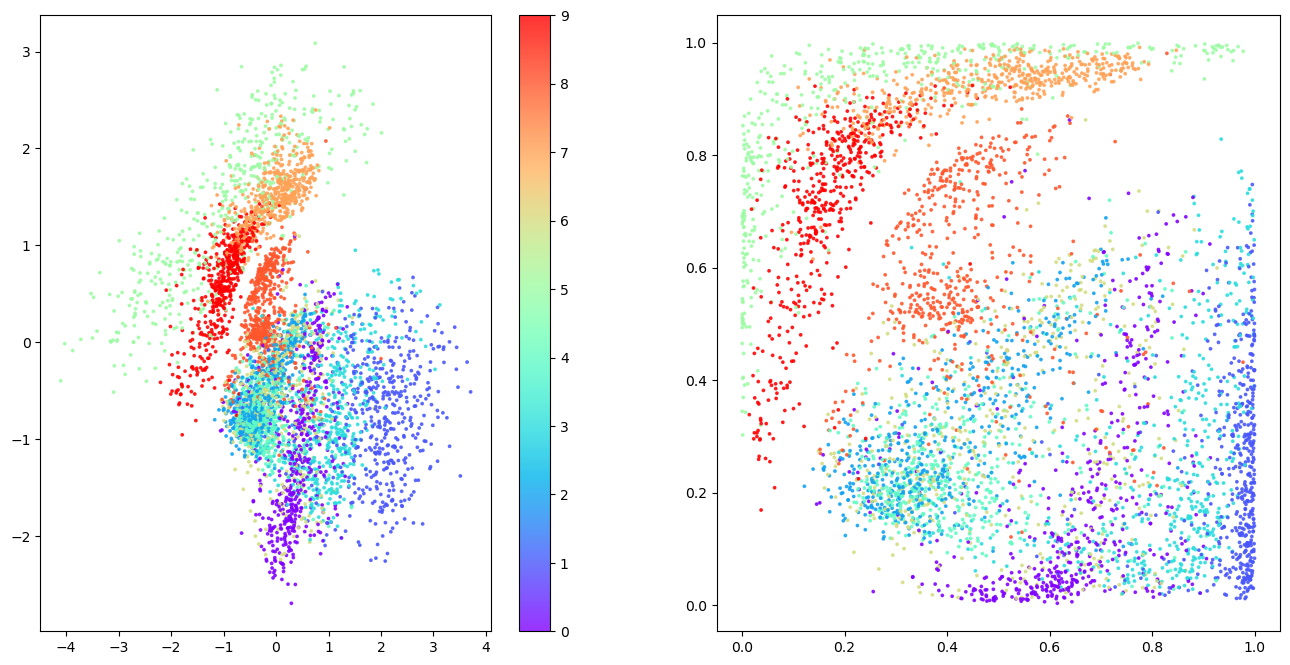

In [23]:



figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

<h3 style="color:#0056b3; text-decoration:underline;">Résultat et Interprétation</h3>

Le modèle présenté dans ce notebook implémente un <strong>Autoencodeur Variationnel (VAE)</strong>, une architecture probabiliste d’apprentissage non supervisé particulièrement adaptée à la génération d’images. Contrairement à un autoencodeur classique, le VAE introduit une contrainte de régularisation via la distribution normale multivariée sur l’espace latent, permettant une meilleure généralisation et une structuration plus continue et exploitable de cet espace.

L’algorithme repose sur deux composantes principales :  
- un <strong>encodeur</strong> qui projette les données dans une distribution gaussienne définie par les paramètres μ (moyenne) et σ (écart-type),  
- un <strong>décoder</strong> qui reconstruit les données à partir d’un échantillon tiré de cette distribution.

La fonction de perte inclut la divergence KL, qui pousse les variables latentes (z_mean et z_log_var) à suivre une distribution normale standard, assurant ainsi la régularité de l’espace latent et la formation d’images générées plus cohérentes.

Les visualisations affichées dans le notebook illustrent la bonne convergence de l’apprentissage :
- La **figure de gauche** montre une interpolation fluide entre les classes de chiffres, mettant en évidence la continuité du codage latent.
- La **figure de droite**, quant à elle, représente l’espace latent coloré par classe, sans biais manifeste et sans que les étiquettes aient été utilisées durant l’entraînement — signe que le modèle a appris une représentation significative de manière non supervisée.

Les reconstructions d’images sont fidèles à leurs entrées, confirmant que le VAE capture des <strong>structures sémantiques</strong> importantes des données. L’espace latent ainsi appris permet également une **génération de nouvelles instances réalistes** et une **modélisation continue et exploitable des variations dans les données**.

En résumé, les VAE constituent une avancée majeure combinant apprentissage non supervisé, compression, et génération contrôlée. Leur capacité à structurer l’espace latent en fait un outil puissant pour des applications allant de la synthèse d’images à l’analyse de représentations profondes.
